### Batch : A-01 
#### Aim : Implement Fuzzy Min Max Neural Network Classifier 

In [41]:
import numpy as np
import pandas as pd

In [42]:
class FuzzyMinMaxNN:
    
    def __init__(self,sensitivity,theta=0.4):
        self.gamma = sensitivity
        self.hyperboxes = {}
        self.clasess = None
        self.V = []
        self.W = []
        self.U = []
        self.hyperbox_class = []
        self.theta = theta
        
        
    def fuzzy_membership(self,x,v,w,gamma=1):
        """
            returns the fuzzy menbership function :
            b_i(xh,v,w) = 1/2n*(------)
        """
        return((sum([max(0,1-max(0,gamma*min(1,x[i]-w[i]))) for i in range(len(x))]) + \
          sum([max(0,1-max(0,gamma*min(1,v[i]-x[i]))) for i in range(len(x))]))/(2*len(x))
         )
    
    def get_hyperbox(self,x,d):
        
        tmp = [0 for i in range(self.clasess)]
        tmp[d[0]-1] = 1
        
        """
            If no hyperbox present initially so create new
        """
        if len(self.V)==0 and len(self.W)==0 :
            self.V.append(x)
            self.W.append(x)
            self.hyperbox_class.append(d)
            self.U.append(tmp)
            expand = False
            return len(self.V)-1 , expand 
                
        """
            returns the most sutaible hyperbox for input pattern x
            otherwise None
        """
        mylist = []
        for i in range(len(self.V)):
            
            if self.hyperbox_class[i]==d:
                mylist.append((self.fuzzy_membership(x,self.V[i],self.W[i])))
            else:
                mylist.append(-1)
                
        if len(mylist)>0:
            for box in sorted(mylist)[::-1]:
                i = mylist.index(box)

                n_theta = sum([(max(self.W[i][_],x[_]) - min(self.V[i][_],x[_])) \
                               for _ in range(len(x))])
                
                if len(x)*self.theta >= n_theta :
                    expand = True
                    return i,expand
            '''
                No hyperbox follow expansion criteria so create new
            '''
            self.V.append(x)
            self.W.append(x)
            self.hyperbox_class.append(d)
            self.U.append(tmp)
            expand = False
            return len(self.V)-1 , expand
            
        else:
            """
                If no hyperbox present for pattern x of class d so create new 
            """
            self.V.append(x)
            self.W.append(x)
            self.hyperbox_class.append(d)
            self.U.append(tmp)
            expand = False
            return len(self.V)-1,expand
    
    def expand(self,x,key):
        self.V[key] = [min(self.V[key][i],x[i]) for i in range(len(x))]
        self.W[key] = [max(self.W[key][i],x[i]) for i in range(len(x))]
        
    
    def overlap_Test(self):
        del_old = 1
        del_new = 1
        box_1,box_2,delta = -1,-1,-1
        for j in range(len(self.V)):
            for k in range(j+1,len(self.V)):
                
                for i in range(len(self.V[j])):
                    
                    """
                        Test Four cases given by Patrick Simpson
                    """
                    
                    if (self.V[j][i] < self.V[k][i] < self.W[j][i] < self.W[k][i]) :
                           del_new = min(del_old,self.V[j][i]-self.V[k][i])
                    elif (self.V[k][i] < self.V[j][i] < self.W[k][i] < self.W[j][i]) :
                           del_new = min(del_old,self.W[k][i]-self.V[j][i])
                    elif (self.V[j][i] < self.V[k][i] < self.W[k][i] < self.W[j][i]) :
                           del_new = min(del_old,min(self.W[k][i]-self.V[j][i],\
                                                     self.W[j][i]-self.V[k][i]))
                    elif (self.V[k][i] < self.V[j][i] < self.W[j][i] < self.W[k][i]) :
                           del_new = min(del_old,min(self.W[j][i]-self.V[k][i],\
                                                     self.W[k][i]-self.V[j][i]))
                       
                    """
                        Check dimension for which overlap is minimum
                    """
                    #print(del_old , del_new , del_old-del_new , i)
                    if del_old - del_new > 0.0 :
                        delta = i
                        box_1,box_2 = j,k
                        del_old = del_new
                        del_new = 1
                    else:
                        pass
                       
        return delta , box_1, box_2 
                       
    def contraction(self,delta,box_1,box_2):
        if (self.V[box_1][delta] < self.V[box_2][delta] < self.W[box_1][delta] < \
            self.W[box_2][delta]) :
            self.W[box_1][delta] = (self.W[box_1][delta]+self.V[box_2][delta])/2
            self.V[box_2][delta] = (self.W[box_1][delta]+self.V[box_2][delta])/2 
            
        elif (self.V[box_2][delta] < self.V[box_1][delta] < self.W[box_2][delta] < \
              self.W[box_1][delta]) :
            self.W[box_2][delta] = (self.W[box_2][delta]+self.V[box_1][delta])/2
            self.V[box_1][delta] = (self.W[box_2][delta]+self.V[box_1][delta])/2
            
        elif (self.V[box_1][delta] < self.V[box_2][delta] < self.W[box_2][delta] < \
              self.W[box_1][delta]) :
            if (self.W[box_2][delta]-self.V[box_1][delta])< \
            (self.W[box_1][delta]-self.V[box_2][delta]):
                self.V[box_1][delta] = self.W[box_2][delta]
            else:
                self.W[box_1][delta] = self.V[box_2][delta]
            
        elif (self.V[box_2][delta] < self.V[box_1][delta] < self.W[box_1][delta] < \
              self.W[box_2][delta]) :
            if (self.W[box_2][delta]-self.V[box_1][delta])<\
            (self.W[box_1][delta]-self.V[box_2][delta]):
                self.W[box_2][delta] = self.V[box_1][delta]
            else:
                self.V[box_2][delta] = self.W[box_1][delta]
    
    def predict(self,x):
        mylist = []
        for i in range(len(self.V)):
            mylist.append([self.fuzzy_membership(x,self.V[i],self.W[i])])
            
        result = np.multiply(mylist,self.U)
        for i in range(self.clasess):
            print('pattern {} belongs to class {} with fuzzy membership value : {}'\
                  .format(x,i+1,max(result[:,i])))
        
            
    def train(self,X,d_,epochs):
        self.clasess = len(np.unique(np.array(d_)))
        for _ in range(epochs):
            print('epoch : {}'.format(_+1))
            print('='*50)

            for x,d in zip(X,d_):
                '''Get most sutaible hyperbox!!'''
                i , expand = self.get_hyperbox(x,d)

                print('input pattern : ',x , d)
                print('Hyperbox : {} , {} '.format(self.V[i],self.W[i])  )

                if expand:
                    self.expand(x,i)
                    print("Expanded Hyperbox : ",self.V[i] , self.W[i])
                    delta,j,k = self.overlap_Test()
                    if delta!=-1:
                        self.contraction(delta,j,k)
                        print("Contracted  Hyperbox 1 : ",self.V[j] , self.W[j])
                        print("Contracted Hyperbox 2 : ",self.V[k] , self.W[k])

                print('='*50)
            
        print('final hyperbox : ')
        print('V : ',self.V)
        print('W : ',self.W)
        


In [43]:
fuzzy = FuzzyMinMaxNN(1,theta=0.3)    

## Dataset

In [44]:
X = [[0.2,0.2],[0.6,0.6],[0.5,0.5],[0.4,0.3],[0.8,0.1],[0.6,0.2],[0.7,0.6],[0.1,0.7],[0.3,0.9],[0.7,0.7],[0.9,0.9]]
d = [[1],[2],[1],[2],[1],[1],[2],[2],[2],[1],[1]]

In [45]:
fuzzy.train(X,d,1)

epoch : 1
input pattern :  [0.2, 0.2] [1]
Hyperbox : [0.2, 0.2] , [0.2, 0.2] 
input pattern :  [0.6, 0.6] [2]
Hyperbox : [0.6, 0.6] , [0.6, 0.6] 
input pattern :  [0.5, 0.5] [1]
Hyperbox : [0.2, 0.2] , [0.2, 0.2] 
Expanded Hyperbox :  [0.2, 0.2] [0.5, 0.5]
input pattern :  [0.4, 0.3] [2]
Hyperbox : [0.6, 0.6] , [0.6, 0.6] 
Expanded Hyperbox :  [0.4, 0.3] [0.6, 0.6]
Contracted  Hyperbox 1 :  [0.2, 0.2] [0.45, 0.5]
Contracted Hyperbox 2 :  [0.42500000000000004, 0.3] [0.6, 0.6]
input pattern :  [0.8, 0.1] [1]
Hyperbox : [0.8, 0.1] , [0.8, 0.1] 
input pattern :  [0.6, 0.2] [1]
Hyperbox : [0.8, 0.1] , [0.8, 0.1] 
Expanded Hyperbox :  [0.6, 0.1] [0.8, 0.2]
Contracted  Hyperbox 1 :  [0.2, 0.2] [0.4375, 0.5]
Contracted Hyperbox 2 :  [0.43125, 0.3] [0.6, 0.6]
input pattern :  [0.7, 0.6] [2]
Hyperbox : [0.43125, 0.3] , [0.6, 0.6] 
Expanded Hyperbox :  [0.43125, 0.3] [0.7, 0.6]
Contracted  Hyperbox 1 :  [0.2, 0.2] [0.434375, 0.5]
Contracted Hyperbox 2 :  [0.43281250000000004, 0.3] [0.7, 0.6]
inpu

### Testing of pattern 

In [46]:
for x in X:
    fuzzy.predict(x)
    print('='*80)

pattern [0.2, 0.2] belongs to class 1 with fuzzy membership value : 1.0
pattern [0.2, 0.2] belongs to class 2 with fuzzy membership value : 0.9166748046875
pattern [0.6, 0.6] belongs to class 1 with fuzzy membership value : 0.95
pattern [0.6, 0.6] belongs to class 2 with fuzzy membership value : 1.0
pattern [0.5, 0.5] belongs to class 1 with fuzzy membership value : 0.983349609375
pattern [0.5, 0.5] belongs to class 2 with fuzzy membership value : 1.0
pattern [0.4, 0.3] belongs to class 1 with fuzzy membership value : 1.0
pattern [0.4, 0.3] belongs to class 2 with fuzzy membership value : 0.9916748046875
pattern [0.8, 0.1] belongs to class 1 with fuzzy membership value : 1.0
pattern [0.8, 0.1] belongs to class 2 with fuzzy membership value : 0.925
pattern [0.6, 0.2] belongs to class 1 with fuzzy membership value : 1.0
pattern [0.6, 0.2] belongs to class 2 with fuzzy membership value : 0.975
pattern [0.7, 0.6] belongs to class 1 with fuzzy membership value : 0.975
pattern [0.7, 0.6] bel

### Visualization of HyperBoxes

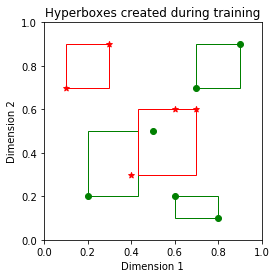

In [47]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_box(ax,a,b,color):
    width = abs(a[0] - b[0])
    height = abs(a[1] - b[1])
    ax.add_patch(patches.Rectangle(a, width, height, fill=False,edgecolor=color))

"""
    plot dataset
"""
fig1 = plt.figure()
ax = fig1.add_subplot(111, aspect='equal',alpha=0.7)

        
"""
    plot Hyperboxes
"""
for i in range(len(fuzzy.V)):
    if fuzzy.hyperbox_class[i]==[1]:
        draw_box(ax,fuzzy.V[i],fuzzy.W[i],color='g')
    else:
        draw_box(ax,fuzzy.V[i],fuzzy.W[i],color='r')
    
for i in range(len(X)):
    if d[i] == [1]:
        ax.scatter(X[i][0],X[i][1] , marker='o', c='g')
    else:
        ax.scatter(X[i][0],X[i][1] , marker='*', c='r')
    
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Hyperboxes created during training')
plt.xlim([0,1])
plt.ylim([0,1])
#plt.legend(('class 1','class 2'))
plt.show()

## Iris Dataset Classification using Fuzzy Min Max NN

In [48]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',names=['PW','PL','SW','SL','Class'])

In [49]:
data['Class'] = data['Class'].replace(['Iris-setosa', 'Iris-versicolor','Iris-virginica'],\
                            [1,2,3])

In [50]:
np.random.shuffle(data.values)

In [51]:
data = data.sample(frac=1) #shuffle dataframe sample

In [52]:
data.head()

,PW,PL,SW,SL,Class
141,6.9,3.1,5.1,2.3,3
57,4.9,2.4,3.3,1.0,2
88,5.6,3.0,4.1,1.3,2
101,5.8,2.7,5.1,1.9,3
64,5.6,2.9,3.6,1.3,2


In [53]:
df = data[['PW','PL','SW','SL']]

In [54]:
df.head()

,PW,PL,SW,SL
141,6.9,3.1,5.1,2.3
57,4.9,2.4,3.3,1.0
88,5.6,3.0,4.1,1.3
101,5.8,2.7,5.1,1.9
64,5.6,2.9,3.6,1.3


In [55]:
normalized_df=(df-df.min())/(df.max()-df.min())

In [56]:
data['Class'].values

array([3, 2, 2, 3, 2, 1, 3, 3, 2, 1, 2, 3, 3, 3, 3, 2, 2, 3, 3, 1, 1, 2, 2,
       1, 3, 3, 3, 3, 3, 1, 2, 3, 3, 2, 2, 3, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1,
       2, 3, 1, 3, 2, 1, 2, 3, 2, 3, 2, 1, 1, 3, 3, 2, 3, 1, 1, 1, 1, 3, 1,
       1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 3, 1, 1, 2, 2, 3,
       1, 1, 2, 3, 3, 2, 2, 3, 2, 3, 2, 3, 2, 1, 1, 1, 3, 2, 1, 3, 3, 2, 3,
       2, 3, 3, 3, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 2, 3, 2, 1, 2, 3, 3,
       2, 1, 3, 1, 3, 2, 2, 3, 2, 3, 3, 2])

In [57]:
#choose 50% training and 50% testing sample
train,test = normalized_df.values[:75,:4],normalized_df.values[75:,:4] 
train_labels,test_labels = data['Class'].values[:75],data['Class'].values[75:]
train_labels,test_labels = train_labels.reshape((-1,1)),test_labels.reshape((-1,1))

In [58]:
train.shape,test.shape

((75, 4), (75, 4))

In [59]:
train_labels.shape,test_labels.shape

((75, 1), (75, 1))

In [60]:
train,test = train.tolist(),test.tolist()
train_labels,test_labels = train_labels.tolist(),test_labels.tolist()

In [70]:
fuzzy = FuzzyMinMaxNN(1,theta=0.05)

In [71]:
fuzzy.train(train,train_labels,1)

epoch : 1
input pattern :  [0.7222222222222222, 0.4583333333333333, 0.6949152542372881, 0.9166666666666666] [3]
Hyperbox : [0.7222222222222222, 0.4583333333333333, 0.6949152542372881, 0.9166666666666666] , [0.7222222222222222, 0.4583333333333333, 0.6949152542372881, 0.9166666666666666] 
input pattern :  [0.1666666666666668, 0.1666666666666666, 0.38983050847457623, 0.375] [2]
Hyperbox : [0.1666666666666668, 0.1666666666666666, 0.38983050847457623, 0.375] , [0.1666666666666668, 0.1666666666666666, 0.38983050847457623, 0.375] 
input pattern :  [0.361111111111111, 0.41666666666666663, 0.5254237288135593, 0.5] [2]
Hyperbox : [0.361111111111111, 0.41666666666666663, 0.5254237288135593, 0.5] , [0.361111111111111, 0.41666666666666663, 0.5254237288135593, 0.5] 
input pattern :  [0.41666666666666663, 0.2916666666666667, 0.6949152542372881, 0.75] [3]
Hyperbox : [0.41666666666666663, 0.2916666666666667, 0.6949152542372881, 0.75] , [0.41666666666666663, 0.2916666666666667, 0.6949152542372881, 0.75]

In [72]:
len(fuzzy.V) , len(fuzzy.W)

(51, 51)

### As Hyperbox created is 4 dimentional we visualize it in 2D so there are 6 possible combinations of 2 dimensions we have 

In [73]:
def show_plot(ax,dim_1,dim_2):
    for i in range(len(fuzzy.V)):
        if fuzzy.hyperbox_class[i]==[1]:
            draw_box(ax,[fuzzy.V[i][_] for _ in \
                    [dim_1-1,dim_2-1]],[fuzzy.W[i][_] for _ in\
                    [dim_1-1,dim_2-1]],color='g')
        elif fuzzy.hyperbox_class[i]==[2]:
            draw_box(ax,[fuzzy.V[i][_] for _ in \
                        [dim_1-1,dim_2-1]],[fuzzy.W[i][_] for _ in \
                        [dim_1-1,dim_2-1]],color='b')
        else:
            draw_box(ax,[fuzzy.V[i][_] for _ in \
                        [dim_1-1,dim_2-1]],[fuzzy.W[i][_] for _ in \
                        [dim_1-1,dim_2-1]],color='r')
    
    for i in range(len(train)):
        if train_labels[i] == [1]:
            ax.scatter(train[i][dim_1-1],train[i][dim_2-1] , marker='o', c='g')
        elif train_labels[i] == [2]:
            ax.scatter(train[i][dim_1-1],train[i][dim_2-1] , marker='o', c='b')
        else:
            ax.scatter(train[i][dim_1-1],train[i][dim_2-1] , marker='o', c='r')
    
    plt.xlabel('Dimension {}'.format(dim_1))
    plt.ylabel('Dimension {}'.format(dim_2))
    plt.title('Dimension {} & {}'.format(dim_1,dim_2))
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.show()

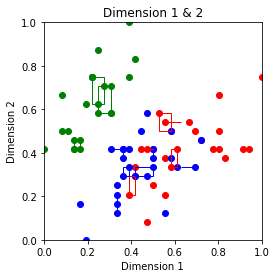

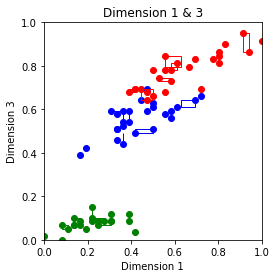

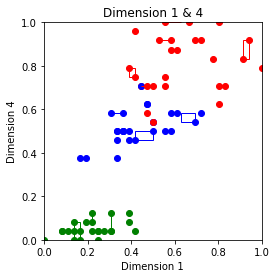

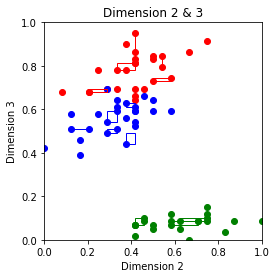

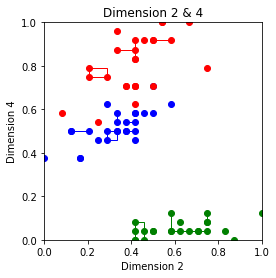

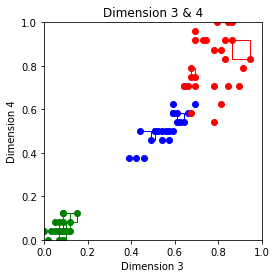

In [74]:
fig1 = plt.figure(1)
ax = fig1.add_subplot(111, aspect='equal',alpha=0.7)
show_plot(ax,1,2)

fig2 = plt.figure(2)
ax = fig2.add_subplot(111, aspect='equal',alpha=0.7)
show_plot(ax,1,3)

fig3 = plt.figure(3)
ax = fig3.add_subplot(111, aspect='equal',alpha=0.7)
show_plot(ax,1,4)

fig4 = plt.figure(4)
ax = fig4.add_subplot(111, aspect='equal',alpha=0.7)
show_plot(ax,2,3)

fig5 = plt.figure(5)
ax = fig5.add_subplot(111, aspect='equal',alpha=0.7)
show_plot(ax,2,4)

fig6 = plt.figure(6)
ax = fig6.add_subplot(111, aspect='equal',alpha=0.7)
show_plot(ax,3,4)



In [75]:
def get_class(x):
        mylist = []
        for i in range(len(fuzzy.V)):
            mylist.append([fuzzy.fuzzy_membership(x,fuzzy.V[i],fuzzy.W[i])])
            
        result = np.multiply(mylist,fuzzy.U)
        mylist=[]
        for i in range(fuzzy.clasess):
            mylist.append(max(result[:,i]))
            
        #print(mylist)
        #print(mylist.index(max(mylist))+1,max(mylist))
        #print('pattern belongs to class {} with fuzzy membership : {}'.format(mylist.index(max(mylist))+1,max(mylist)))
        return [mylist.index(max(mylist))+1]
      

In [76]:
def score(train,train_labels):
    counter=0
    wronge=0
    for i in range(len(train)):
        if get_class(train[i]) == train_labels[i] :
            counter+=1
        else:
            wronge+=1
            
    print('No of misclassification : {}'.format(wronge))
    return (counter/len(train_labels))*100

In [77]:
print('Accuracy : {} %'.format(score(train,train_labels)))

No of misclassification : 0
Accuracy : 100.0 %


In [78]:
print('Accuracy (test) : {} %'.format(score(test,test_labels)))

No of misclassification : 3
Accuracy (test) : 96.0 %
